In [1]:
# %pip install scipy
# %pip install ripser gudhi
# %pip install scikit-tda
# %pip install numpy
# %pip install tqdm
# %pip install networkx
# %pip install persim

## 1. Preprocessing

In [2]:
from src.preprocessing.preprocessing import *


VR persistence diagram with Ripser

In [3]:
import os
from src.shape.shape import *
from tqdm.notebook import tqdm
# Load preprocessed data

data_path = "data/preprocessed/"
shape_paths = []
for file in os.listdir(data_path):
    if file.endswith(".mat"):
        shape_paths.append(data_path + file)
shape_paths.sort()
print(f"Found {len(shape_paths)} shapes... {shape_paths[0], shape_paths[1]}, ...")

shapes = []
for f in tqdm(shape_paths, desc="Loading shapes"):
    shapes.append(load_from_mat(f))
    
print(f"Loaded {len(shapes)} shapes... {shapes[0], shapes[1]}, ...")


# Load Euclidean Preprocessed data
data_path = "data/preprocessed_euclidean/euclidean/"
euclidean_shape_paths = []
for file in os.listdir(data_path):
    if file.endswith(".mat"):
        euclidean_shape_paths.append(data_path + file)

print(f"Found {len(euclidean_shape_paths)} shapes... {euclidean_shape_paths[0], euclidean_shape_paths[1]}, ...")

euclidean_shapes = []
for f in tqdm(euclidean_shape_paths, desc="Loading shapes"):
    euclidean_shapes.append(load_from_mat(f))

Found 148 shapes... ('data/preprocessed/pre_geodesic_gorilla8.mat', 'data/preprocessed/pre_geodesic_victoria1.mat'), ...


Loading shapes:   0%|          | 0/148 [00:00<?, ?it/s]

Loaded 148 shapes... (<src.shape.shape.Shape object at 0x13f7d8a90>, <src.shape.shape.Shape object at 0x13ff23150>), ...
Found 148 shapes... ('data/preprocessed_euclidean/euclidean/pre_geodesic_gorilla8.mat', 'data/preprocessed_euclidean/euclidean/pre_geodesic_victoria1.mat'), ...


Loading shapes:   0%|          | 0/148 [00:00<?, ?it/s]

Computing dDiam matrix:   0%|          | 0/10952.0 [00:00<?, ?it/s]

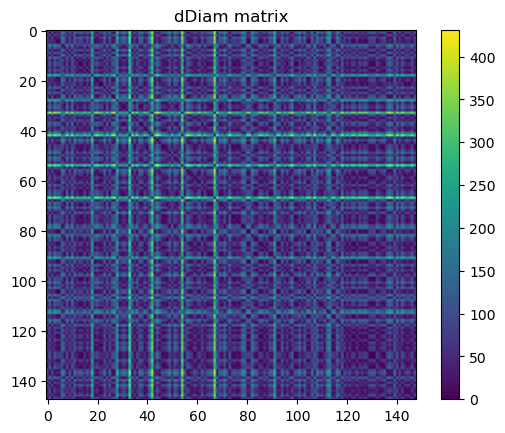

In [6]:
from tqdm.notebook import tqdm
dDiam_matrix = np.zeros((len(shapes), len(shapes)))


tqdm_bar = tqdm(total=len(shapes)**2 / 2, desc = "Computing dDiam matrix")
for i in range(len(shapes)):
    for j in range(i+1, len(shapes)):
        dDiam_matrix[i,j] = dDiam(shapes[i], shapes[j])
        dDiam_matrix[j,i] = dDiam_matrix[i,j]
        tqdm_bar.update(1)

# plot dDiam matrix
import matplotlib.pyplot as plt
plt.imshow(dDiam_matrix)
plt.colorbar()
plt.title("dDiam matrix")
plt.savefig("dDiam_matrix.png")
plt.show()

np.savetxt("data/dDiam_matrix.csv", dDiam_matrix, delimiter=",")
    

Computing d_E_inf matrix:   0%|          | 0/10952.0 [00:00<?, ?it/s]

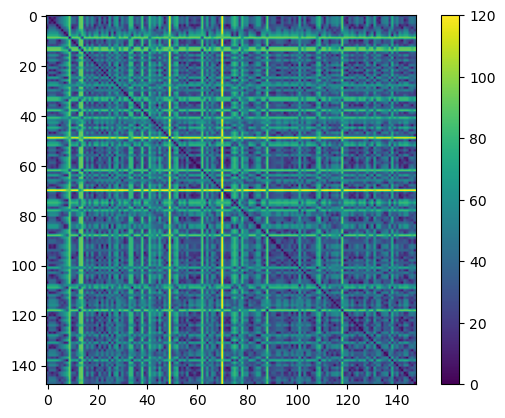

In [7]:
d_E_inf_matrix = np.zeros((len(shapes), len(shapes)))

tqdm_bar = tqdm(total=len(shapes)**2 / 2, desc = "Computing d_E_inf matrix")
for i in range(len(shapes)):
    for j in range(i+1, len(shapes)):
        d_E_inf_matrix[i,j] = d_E_inf(euclidean_shapes[i], euclidean_shapes[j])
        d_E_inf_matrix[j,i] = d_E_inf_matrix[i,j]
        tqdm_bar.update(1)

# plot distance matrix
import matplotlib.pyplot as plt
plt.imshow(d_E_inf_matrix)
plt.colorbar()
plt.show()


np.savetxt("data/d_E_inf_matrix.csv", d_E_inf_matrix, delimiter=",")
    

Computing d_G_1 and g_G_inf matrix:   0%|          | 0/10952.0 [00:00<?, ?it/s]

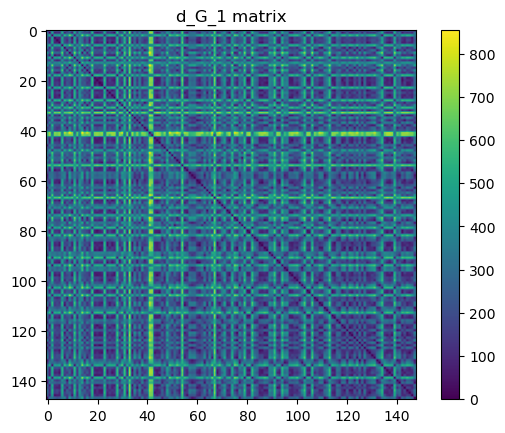

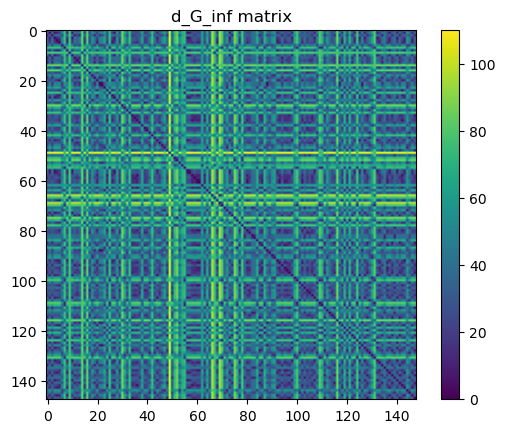

In [8]:
d_G_1_matrix = np.zeros((len(shapes), len(shapes)))
d_G_inf_matrix = np.zeros((len(shapes), len(shapes)))

tqdm_bar = tqdm(total=len(shapes)**2 / 2, desc = "Computing d_G_1 and g_G_inf matrix")
for i in range(len(shapes)):
    for j in range(i+1, len(shapes)):
        d_G_1_matrix[i,j] = d_G_wasserstein(shapes[i], shapes[j], q=1)
        d_G_inf_matrix[i,j] = d_G_wasserstein(shapes[i], shapes[j], q=np.inf)
        d_G_1_matrix[j,i] = d_G_1_matrix[i,j]
        d_G_inf_matrix[j,i] = d_G_inf_matrix[i,j]
        tqdm_bar.update(1)


# plot distance matrix
import matplotlib.pyplot as plt
plt.figure(0)
plt.imshow(d_G_1_matrix)
plt.colorbar()
plt.title("d_G_1 matrix")
plt.show()

plt.figure(1)
plt.imshow(d_G_inf_matrix)
plt.colorbar()
plt.title("d_G_inf matrix")
plt.show()

np.savetxt("data/d_G_1_matrix.csv", d_G_1_matrix, delimiter=",")

np.savetxt("data/d_G_inf_matrix.csv", d_G_inf_matrix, delimiter=",")




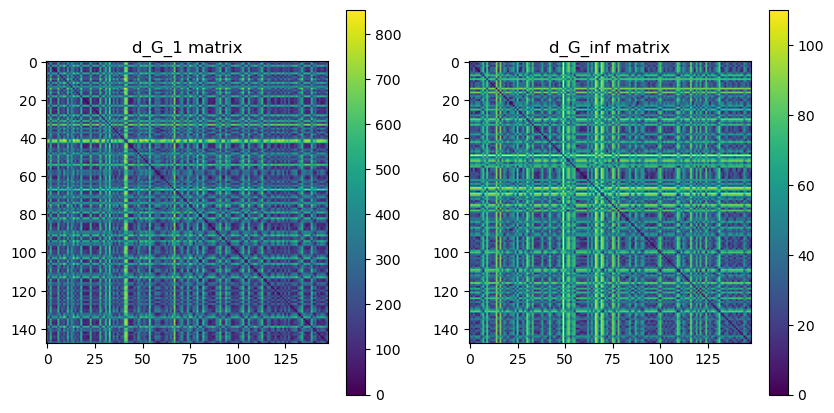

In [13]:
plt.subplots(1,2, figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(d_G_1_matrix)
plt.colorbar()
plt.title("d_G_1 matrix")
plt.subplot(1,2,2)
plt.imshow(d_G_inf_matrix)
plt.colorbar()
plt.title("d_G_inf matrix")
plt.savefig("d_G_matrix.png")
plt.show()


Computing dG_inf_bottleneck matrix:   0%|          | 0/148 [00:00<?, ?it/s]

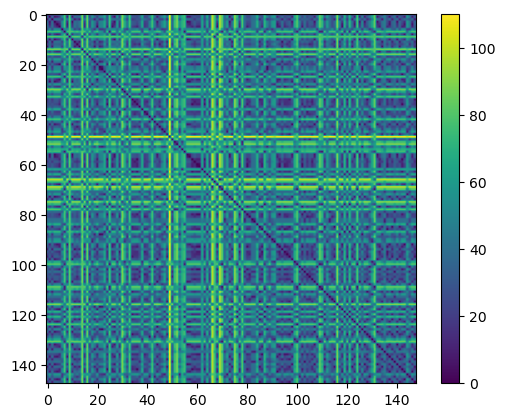

In [9]:
from src.shape import *
dG_inf_bottleneck_matrix = np.zeros((len(shapes), len(shapes)))

for i in tqdm(range(len(shapes)), desc="Computing dG_inf_bottleneck matrix"):
    for j in range(i+1, len(shapes)):
        dG_inf_bottleneck_matrix[i,j] = d_G_bottleneck(shapes[i], shapes[j])
        dG_inf_bottleneck_matrix[j,i] = dG_inf_bottleneck_matrix[i,j]

# plot distance matrix
import matplotlib.pyplot as plt
plt.imshow(dG_inf_bottleneck_matrix)
plt.colorbar()
plt.show()


### Dendrogram

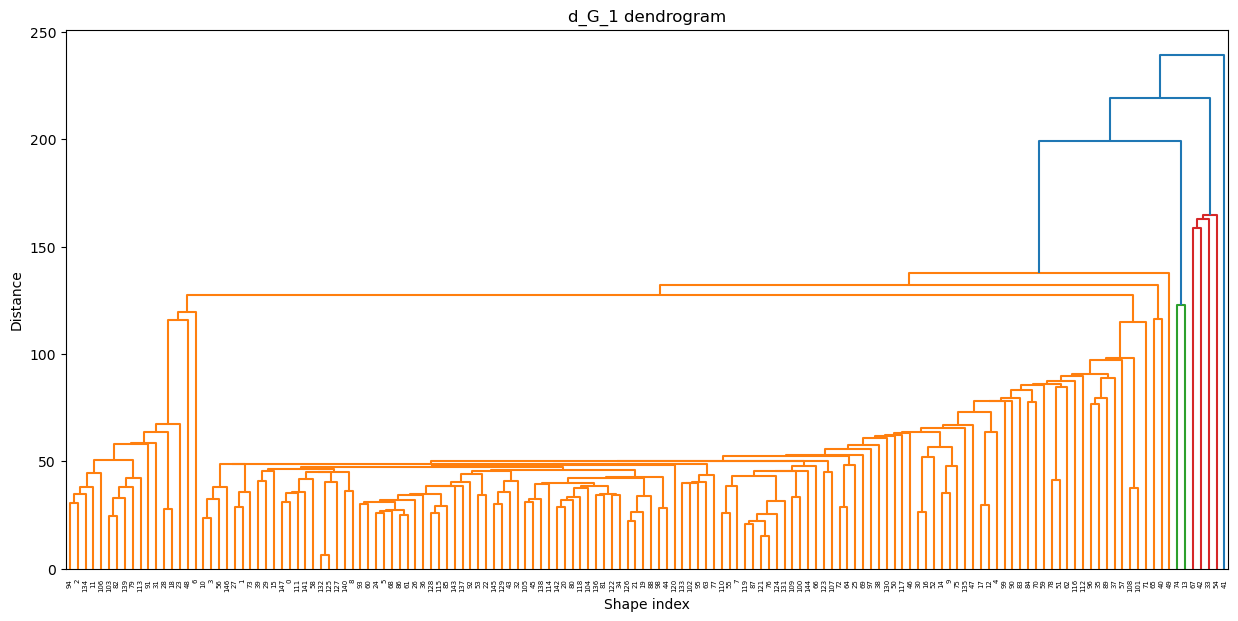

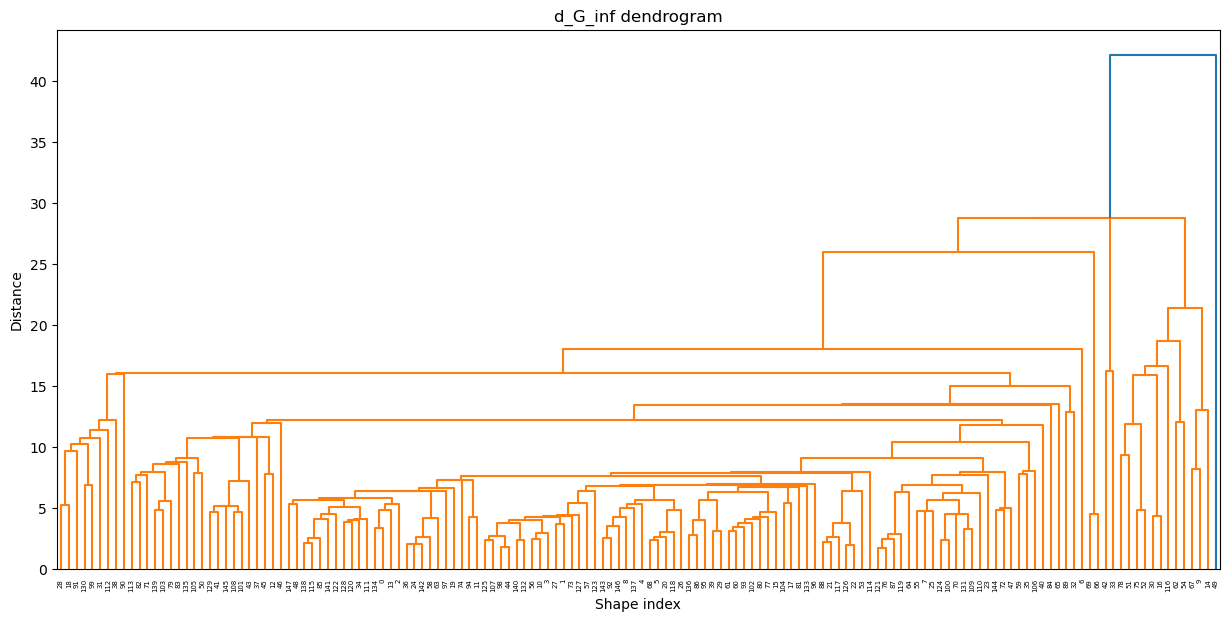

In [10]:
from scipy.cluster.hierarchy import single, dendrogram
from scipy.spatial.distance import squareform

converted_d_G_1_matrix = squareform(d_G_1_matrix, checks= False)
converted_d_G_inf_matrix = squareform(d_G_inf_matrix, checks= False)

linked_d_G_1 = single(converted_d_G_1_matrix)
linked_d_G_inf = single(converted_d_G_inf_matrix)

plt.figure(0, figsize=(15, 7))
dendrogram(linked_d_G_1, orientation='top', distance_sort='descending', show_leaf_counts=False)
plt.title("d_G_1 dendrogram")
plt.xlabel("Shape index")
plt.ylabel("Distance")
plt.show()

plt.figure(1, figsize=(15, 7))
dendrogram(linked_d_G_inf, orientation='top', distance_sort='descending', show_leaf_counts=False)
plt.title("d_G_inf dendrogram")
plt.xlabel("Shape index")
plt.ylabel("Distance")
plt.show()



## Multidimensional scaling Plot

/Users/youngmin/mambaforge/envs/tda_newer/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/Users/youngmin/mambaforge/envs/tda_newer/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


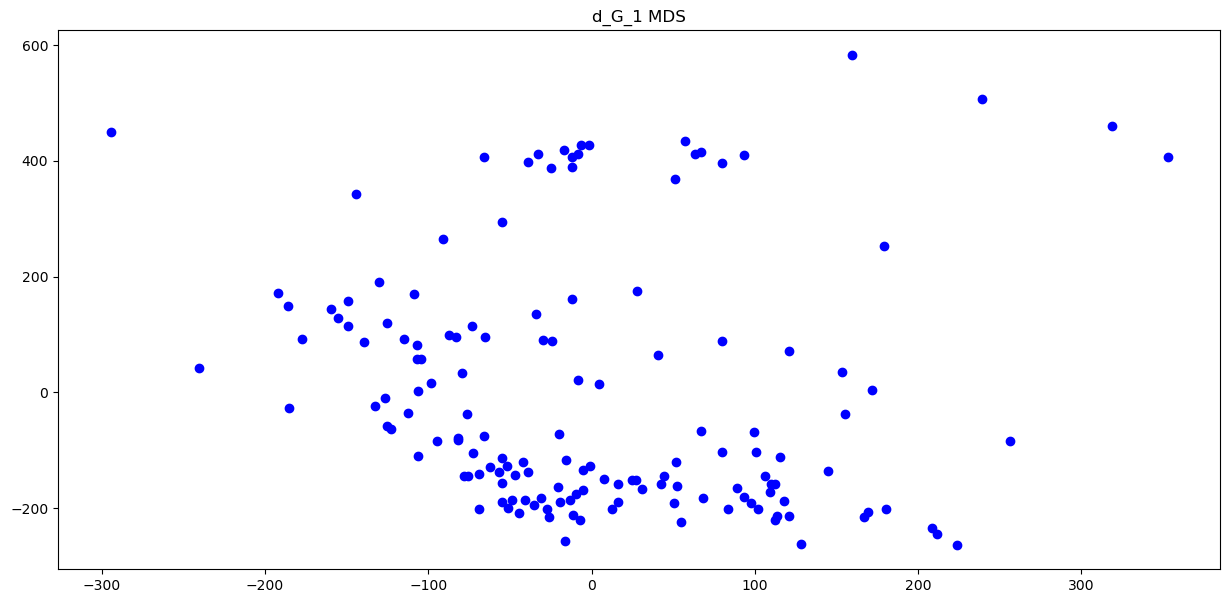

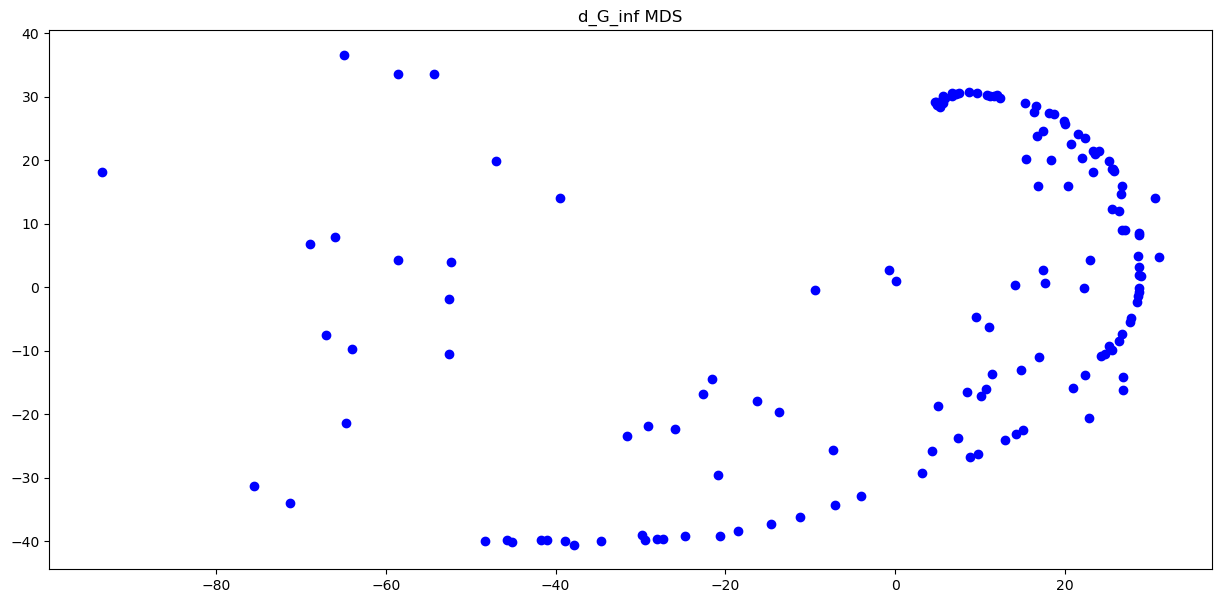

In [14]:
from sklearn.manifold import MDS

mds_d_G_1 = MDS(n_components=2, dissimilarity="precomputed", random_state=0)
mds_d_G_inf = MDS(n_components=2, dissimilarity="precomputed", random_state=0)

mds_result_d_G_1 = mds_d_G_1.fit_transform(d_G_1_matrix)
mds_result_d_G_inf = mds_d_G_inf.fit_transform(d_G_inf_matrix)

plt.figure(0, figsize=(15, 7))
plt.scatter(mds_result_d_G_1[:,0], mds_result_d_G_1[:,1], c='blue', marker = 'o')
plt.title("d_G_1 MDS")
plt.show()

plt.figure(1, figsize=(15, 7))
plt.scatter(mds_result_d_G_inf[:,0], mds_result_d_G_inf[:,1], c='blue', marker = 'o')
plt.title("d_G_inf MDS")
plt.show()
